<a href="https://colab.research.google.com/github/HongJieYang/Age-Gender-Emotion-Detector/blob/main/Gender_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# VGGFace based on vgg16 architecture
from IPython.display import clear_output
!pip install keras_vggface
clear_output()

In [ ]:
# Required for VGGFace
!pip install keras_applications
clear_output()

In [ ]:
# Set up directory
import os
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
os.chdir('/content')

Mounted at /content/drive


In [ ]:
# Create local copy 
!cp "/content/drive/MyDrive/test/faces.zip" .
!unzip -q "/content/faces.zip"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from PIL import Image

## **Load and Organize the Images Based on Gender**

In [ ]:
# load data (Downloaded from https://talhassner.github.io/home/projects/Adience/Adience-data.html)
# Need fold_0_data.txt to fold_4_data.txt, and faces.zip
os.chdir('/content/drive/MyDrive/data')
fold_0 = pd.read_csv("fold_0_data.txt",sep = "\t" )
fold_1 = pd.read_csv("fold_1_data.txt",sep = "\t")
fold_2 = pd.read_csv("fold_2_data.txt",sep = "\t")
fold_3 = pd.read_csv("fold_3_data.txt",sep = "\t")
fold_4 = pd.read_csv("fold_4_data.txt",sep = "\t")

In [ ]:
# Combined data_set
total_data = pd.concat([fold_0, fold_1, fold_2, fold_3, fold_4], ignore_index=True)
print(total_data.shape)
total_data.info()
total_data.head()

(19370, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             19370 non-null  object
 1   original_image      19370 non-null  object
 2   face_id             19370 non-null  int64 
 3   age                 19370 non-null  object
 4   gender              18591 non-null  object
 5   x                   19370 non-null  int64 
 6   y                   19370 non-null  int64 
 7   dx                  19370 non-null  int64 
 8   dy                  19370 non-null  int64 
 9   tilt_ang            19370 non-null  int64 
 10  fiducial_yaw_angle  19370 non-null  int64 
 11  fiducial_score      19370 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.8+ MB


,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


In [ ]:
# Remove pictures with missing data
df = total_data.replace('None', np.nan).dropna()
print(df['gender'].value_counts())

f    9332
m    8120
u    1099
Name: gender, dtype: int64


In [ ]:
# Remove pictures with undefined data
df = df.drop(df[df.gender == 'u'].index)
print(df['gender'].value_counts())

f    9332
m    8120
Name: gender, dtype: int64


## **Prepare Pictures for Data Loader Based on Gender**

In [ ]:
import shutil
folder_path = "/content/faces/faces"

In [ ]:
# Generate list of picture paths
file_list = []
formats = ["jpg", "png"]

for subdir in os.listdir(folder_path):
    subpath = os.path.join(folder_path, subdir)

    if os.path.isdir(subpath):

        for f in os.listdir(subpath):
      
            filepath = os.path.join(subpath, f)
            part = f.split(".")
      
            if os.path.isfile(filepath) and part[-1] in formats: # Is jpg or png
                file_list.append((filepath, f))

print(len(file_list))
print(file_list[0])

19370
('/content/faces/faces/37303189@N08/coarse_tilt_aligned_face.84.10384336703_e439941d25_o.jpg', 'coarse_tilt_aligned_face.84.10384336703_e439941d25_o.jpg')


In [ ]:
(filepath, filename) = file_list[0]

# get the identifiers
parts = filename.split(".")
user_id = filepath.split("/")[-2]
file_id = parts[-2] + "." + parts[-1]
face_id = int(parts[-3])

print(filepath)
print(filename)
print(parts)
print(user_id)
print(file_id)
print(face_id)

# Get the class value from the gender column
class_ = df[
  (df["user_id"] == user_id) & 
  (df["original_image"] == file_id) & 
  (df["face_id"] == face_id)
]["gender"].values[0]

new_path = os.path.join(folder_path, class_)

print(class_)
print(new_path)

/content/faces/faces/37303189@N08/coarse_tilt_aligned_face.84.10384336703_e439941d25_o.jpg
coarse_tilt_aligned_face.84.10384336703_e439941d25_o.jpg
['coarse_tilt_aligned_face', '84', '10384336703_e439941d25_o', 'jpg']
37303189@N08
10384336703_e439941d25_o.jpg
84
m
/content/faces/faces/m


In [ ]:
# Sort pictures into different folders based on it's class label
im_len = len(file_list)
for i, (filepath, filename) in enumerate(file_list):

    # get the identifiers
    parts = filename.split(".")
    user_id = filepath.split("/")[-2]
    file_id = parts[-2] + "." + parts[-1]
    face_id = int(parts[-3])

    try:

      # find class
      class_ = df[
        (df["user_id"] == user_id) & 
        (df["original_image"] == file_id) & 
        (df["face_id"] == face_id)
      ]["gender"].values[0]

      new_path = os.path.join(folder_path, class_)

      # Make a new directory if it doesn't already exist      
      if not os.path.exists(new_path):
          os.makedirs(new_path)

      # move file
      new_path = os.path.join(new_path, filename)
      shutil.move(filepath, new_path)
    
    except:
      pass

    # progress
    prog = (20 * (i + 1)) // im_len
    print("\r[" + "="*prog + "_"*(20-prog) + "]", end="")\

[====================]

In [ ]:
# delete unwanted files or empty folders
for subdir in os.listdir(folder_path):
    subpath = os.path.join(folder_path, subdir)

    if os.path.isdir(subpath):

        if subdir[0] != "f" and subdir[0] != "m":
            shutil.rmtree(subpath)
            
    elif os.path.isfile(subpath):
        os.remove(subdir)

In [ ]:
import keras
from keras.applications.vgg16 import VGG16

## **Split Up Folders into Training, Validation, and Testing Datasets**

In [ ]:
!pip install split-folders
clear_output()

In [ ]:
import splitfolders
splitfolders.ratio("/content/faces/faces", output="/content/output", seed=1337, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 17452 files [00:08, 1971.57 files/s]


In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [ ]:
IMAGE_SIZE = [224, 224]

train_path = "/content/output/train"
valid_path = "/content/output/val"
test_path  = "/content/output/test"

## **Train the Model Based on VGGFace Architecture**

In [ ]:
# Need to replace 'from keras.engine.topology import get_source_inputs with' 
# 'from tensorflow.keras.utils import get_source_inputs' in models.py
from keras_vggface.vggface import VGGFace

vgg_features = VGGFace(include_top=False, input_shape=(224, 224, 3), pooling='avg')

58925056/58909280 [==============================] - 2s 0us/step


In [ ]:
# Using feature extraction transfer learing, freeze base layer's parameters
for layer in vgg_features.layers:
    layer.trainable = False

print(vgg_features.summary())

Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)     

In [ ]:
# Number of output classes
folders = glob('/content/output/train/*')

# Add dense and dropout layers to perform the predictions
test_model = Model(inputs=vgg_features.input, outputs=vgg_features.layers[-2].output)
x = Flatten()(test_model.output)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.6)(x)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=test_model.input, outputs=prediction)

print(model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0   

In [ ]:
# Set up cost and optimizer 
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.0001)

model.compile(
  loss=tf.keras.losses.BinaryCrossentropy(),
  optimizer=opt,
  metrics=tf.keras.metrics.BinaryAccuracy()
)

In [ ]:
# Use the Image Data Generator to import the images from the dataset, apply distortions to the training dataset only
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 13961 images belonging to 2 classes.


In [ ]:
val_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1745 images belonging to 2 classes.


In [ ]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 1,
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 1746 images belonging to 2 classes.


In [ ]:
# Fit the model
r = model.fit(
  training_set,
  validation_data=val_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(val_set)
)

Epoch 1/5
437/437 [==============================] - 241s 546ms/step - loss: 0.2583 - binary_accuracy: 0.8970 - val_loss: 0.1634 - val_binary_accuracy: 0.9324
Epoch 2/5
437/437 [==============================] - 220s 503ms/step - loss: 0.1807 - binary_accuracy: 0.9265 - val_loss: 0.1438 - val_binary_accuracy: 0.9370
Epoch 3/5
437/437 [==============================] - 219s 501ms/step - loss: 0.1584 - binary_accuracy: 0.9381 - val_loss: 0.1647 - val_binary_accuracy: 0.9312
Epoch 4/5
437/437 [==============================] - 218s 499ms/step - loss: 0.1335 - binary_accuracy: 0.9482 - val_loss: 0.1273 - val_binary_accuracy: 0.9473
Epoch 5/5
437/437 [==============================] - 218s 499ms/step - loss: 0.1163 - binary_accuracy: 0.9537 - val_loss: 0.1200 - val_binary_accuracy: 0.9547


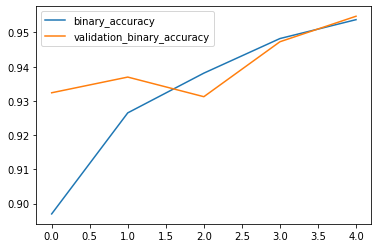

In [ ]:
plt.plot(r.history['binary_accuracy'], label='binary_accuracy')
plt.plot(r.history['val_binary_accuracy'], label='validation_binary_accuracy')
plt.legend()
plt.show()

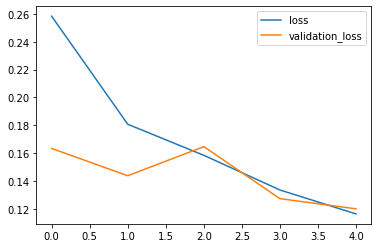

In [ ]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='validation_loss')
plt.legend()
plt.show()

## **Model Performance Results**

In [ ]:
model.save('/content/model/')

INFO:tensorflow:Assets written to: /content/model/assets


In [ ]:
from tensorflow import keras
test_model = keras.models.load_model('/content/model/')

In [ ]:
# Get list of pictures from test set
filenames = test_set.filenames
num_samples = len(filenames)

In [ ]:
# Get predictions for the test set
y_pred = model.predict(test_set, steps=num_samples)
pred = np.argmax(y_pred, axis=1)

In [ ]:
# Convert one hot encoding to integer and calculate total accuracy 
labels = []
count = 0
for i in range(len(pred)):

  labels.append(np.argmax(test_set[i][1][0]))

  if test_set[i][1][0][pred[i]] == 1:
    count = count + 1

labels = np.asarray(labels)

In [ ]:
print(count)
print(count / len(pred))

1656
0.9484536082474226


In [ ]:
# Confusion matrix
confusion = tf.math.confusion_matrix(labels=labels, predictions=pred, num_classes=2).numpy()
norm_confusion = np.around(confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis], decimals=2)

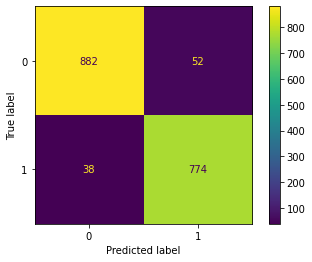

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(labels, pred)

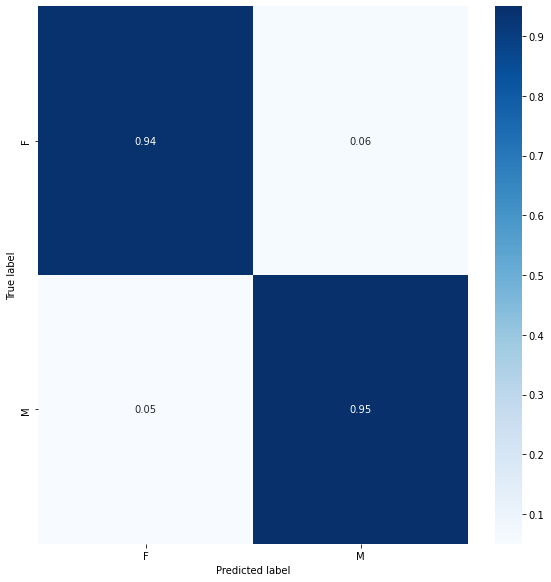

In [ ]:
# Normalized confusion matrix
classes = ["F", "M"]
con_mat_df = pd.DataFrame(norm_confusion,
                     index = classes, 
                     columns = classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Male
Male


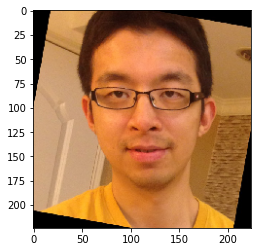

In [ ]:
# Test result of models
gender_dict = {
    0: "Female",
    1: "Male"
}

nums = 1136

img = test_set[nums][0]
img = np.squeeze(img)
print(gender_dict[pred[nums]])
print(gender_dict[np.argmax(test_set[nums][1][0])])
plt.imshow(img[:, :, :])

In [ ]:
# Export model as zip
shutil.make_archive("model_gender", "zip", "/content/model")

'/content/drive/MyDrive/data/model_gender.zip'